In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


Columnas disponibles: ['fecha', 'monto_recibido', 'precio', 'total', 'precio_compra', 'fecha_vencimiento', 'nombre', 'cantidad_total', 'nombre_limpio', 'categoria_diccionario', 'cluster', 'categoria_cluster', 'categoria_final', 'categoria_final_unificada']
Número de registros: 52093

📊 Total de categorías: 42

🔹 Procesando categoría: Higiene / Dental


c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d

  Modelo óptimo: ARIMA(5, 1, 0) x (0, 0, 0, 7)


c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


  MAE=0.07, RMSE=0.32, MAPE=100.00%


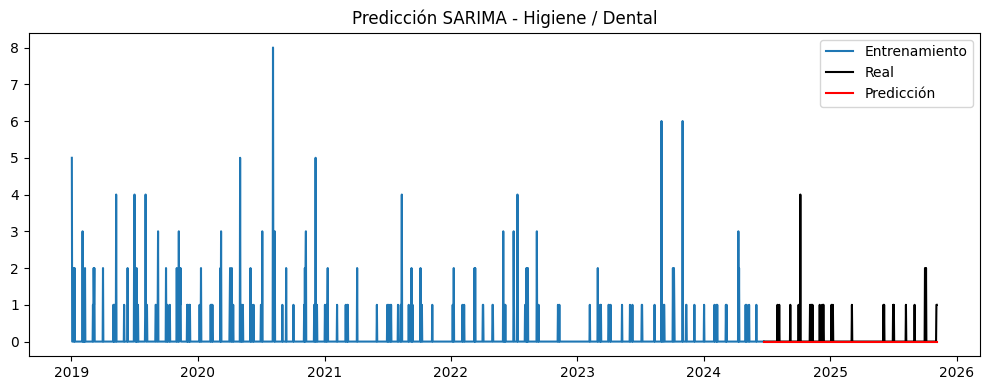


🔹 Procesando categoría: Analgésico / Antipirético


c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Jeimi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\d

KeyboardInterrupt: 

In [1]:
# === 1. Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# === 2. Cargar datos ===
df = pd.read_csv("../output/dataset_farmacia_categorizado_unificado.csv")

# Asegurar formato de fecha
df["fecha"] = pd.to_datetime(df["fecha"], errors="coerce")
df = df.dropna(subset=["fecha"])
df = df.sort_values("fecha")

print("Columnas disponibles:", df.columns.tolist())
print(f"Número de registros: {len(df)}")

# === 3. Verificar columnas necesarias ===
if "categoria_final" not in df.columns or "cantidad_total" not in df.columns:
    raise ValueError("❌ El dataset debe tener las columnas 'categoria_final' y 'cantidad_total'.")

# === 4. Función SARIMA por categoría ===
def entrenar_sarima_por_categoria(df, categoria, test_size=0.2):
    print(f"\n🔹 Procesando categoría: {categoria}")

    data_cat = df[df["categoria_final"] == categoria].copy()
    data_cat = data_cat.groupby("fecha")["cantidad_total"].sum().asfreq("D").fillna(0)

    # Si no hay suficientes datos, saltar
    if len(data_cat) < 60 or data_cat.sum() == 0:
        print("⚠️ Muy pocos datos o todos ceros, se omite esta categoría.")
        return None

    # División train/test
    split = int(len(data_cat) * (1 - test_size))
    train, test = data_cat[:split], data_cat[split:]

    try:
        # Auto ARIMA
        model_auto = auto_arima(
            train, seasonal=True, m=7,
            trace=False, error_action="ignore", suppress_warnings=True
        )

        print(f"  Modelo óptimo: ARIMA{model_auto.order} x {model_auto.seasonal_order}")

        # Ajustar SARIMA
        model = SARIMAX(train, 
                        order=model_auto.order, 
                        seasonal_order=model_auto.seasonal_order,
                        enforce_stationarity=False, 
                        enforce_invertibility=False)
        results = model.fit(disp=False)

        # Pronóstico
        forecast = results.get_forecast(steps=len(test)).predicted_mean
        forecast.index = test.index

        # Métricas
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mask = test != 0
        mape = np.mean(np.abs((test[mask] - forecast[mask]) / test[mask])) * 100 if mask.sum() > 0 else np.nan

        print(f"  MAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%")

        # === Gráfico ===
        plt.figure(figsize=(10, 4))
        plt.plot(train, label="Entrenamiento")
        plt.plot(test, label="Real", color="black")
        plt.plot(forecast, label="Predicción", color="red")
        plt.title(f"Predicción SARIMA - {categoria}")
        plt.legend()
        plt.tight_layout()
        plt.show()

        return {"Categoria": categoria, "MAE": mae, "RMSE": rmse, "MAPE": mape}

    except Exception as e:
        print(f"⚠️ Error en categoría {categoria}: {e}")
        return None

# === 5. Ejecutar por categoría_final ===
categorias = df["categoria_final"].unique()
print(f"\n📊 Total de categorías: {len(categorias)}")

resultados = []
for cat in categorias:
    res = entrenar_sarima_por_categoria(df, cat)
    if res:
        resultados.append(res)

# === 6. Tabla final ===
if len(resultados) == 0:
    print("\n⚠️ No se generaron resultados válidos. Revisa si las categorías tienen datos suficientes.")
else:
    resultados_df = pd.DataFrame(resultados)
    resultados_df = resultados_df.sort_values("MAPE")
    print("\n=== Resultados por Categoría (SARIMA) ===")
    print(resultados_df)

    # Guardar resultados
    resultados_df.to_csv("resultados_sarima_por_categoria.csv", index=False)
    print("\n✅ Resultados guardados en 'resultados_sarima_por_categoria.csv'")
